In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import random


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 2

captions_path = 'text_c10'
img_name_path = 'images.txt'
data_path = 'images/'

word_counts = defaultdict(float)

In [2]:
name_id = open(img_name_path).read().splitlines()
name2id_train = {}
id2name_train = {}
for index, img in enumerate (name_id):
        name2id_train[img.split(' ')[1]] = img.split(' ')[0]
        id2name_train[img.split(' ')[0]] = img.split(' ')[1]

id2caption_train = {}

for name in name2id_train:
    txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
    txt_path = os.path.join(captions_path, txt_name)
    idx = name2id_train[name]
    id2caption_train[idx] = open(txt_path,  encoding='utf-8').read().splitlines()

In [3]:
all_captions =[]
from nltk.tokenize import RegexpTokenizer
for i, captions in enumerate(id2caption_train.values()):
    for cap in captions:
        if len(cap) == 0:
            continue
        cap = cap.replace(u"\ufffd\ufffd", u" ")

        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(cap.lower())

        if len(tokens) == 0:
            print('cap', cap)
            continue

        tokens_new = []
        for t in tokens:
            t = t.encode('ascii', 'ignore').decode('ascii')
            if len(t) > 0:
                tokens_new.append(t)
        all_captions.append(tokens_new)
        
word_counts = defaultdict(float)
captions = all_captions
for sent in captions:
    for word in sent:
        word_counts[word] += 1

vocab = [w for w in word_counts if word_counts[w] >= 0]

ixtoword = {}
ixtoword[0] = '<end>'
wordtoix = {}
wordtoix['<end>'] = 0
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [4]:
print(len(wordtoix))

5450


In [5]:
class DataLoader:
    def __init__(self):
        self.device = device
        self.batch_size = batch_size
        self.data_path = data_path
        name_id = open(img_name_path).read().splitlines()
        
#         random.shuffle(name_id)
        
        name2id_train = {}
        id2name_train = {}
        name2id_test = {}
        id2name_test = {}
        for index, img in enumerate (name_id):
            if(len(name2id_train) < 9430):
                name2id_train[img.split(' ')[1]] = img.split(' ')[0]
                id2name_train[img.split(' ')[0]] = img.split(' ')[1]
            else:
                name2id_test[img.split(' ')[1]] = img.split(' ')[0]
                id2name_test[img.split(' ')[0]] = img.split(' ')[1]
       
        id2caption_train = {}
        id2caption_test = {}
        
        for name in name2id_train:
            txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
            txt_path = os.path.join(captions_path, txt_name)
            idx = name2id_train[name]
            id2caption_train[idx] = open(txt_path,  encoding='utf-8').read().splitlines()
        
        for name in name2id_test:
            txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
            txt_path = os.path.join(captions_path, txt_name)
            idx = name2id_test[name]
            id2caption_test[idx] = open(txt_path,  encoding='utf-8').read().splitlines()
        
        self.name2id_train = name2id_train
        self.id2name_train = id2name_train
        self.name2id_test = name2id_test
        self.id2name_test = id2name_test
        
        self.id2caption_train = id2caption_train
        self.id2caption_test = id2caption_test
        
        self.data_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize([256, 256]),
#                 torchvision.transforms.CenterCrop(256),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

#         self.text_transforms = torchvision.transforms.Compose([
# #             torchvision.transforms.ToTensor()
#             #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])
        
    def load_img(self, image_name):
        image = Image.open(image_name)
        image = self.data_transforms(image).float()
        image = torch.autograd.Variable(image, requires_grad=False)
        image = image.unsqueeze(0)
        return image[0].to(device)
    
    def imshow(self, img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.cpu().detach().numpy()
        plt.figure(figsize = (5,5))
        plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')
        
    def padding(self, unpadded):
        l = []
        for i in unpadded:
            for j in i:
                l.append([len(j)])
        lens = np.array(l)   
        mask = lens[:,None] > np.arange(lens.max())
        out = np.full(mask.shape,0)
        out[mask] = np.concatenate(np.concatenate(unpadded))
        out = out.reshape(len(unpadded),10,-1)
        return torch.LongTensor(out)
    
    def get_data(self, train=True):
        if train == True:
            images = self.id2name_train
            lb = self.id2caption_train
        else:
            images = self.test_id2name_test
            lb = self.id2caption_test
        while True:
            ix = np.random.choice(np.arange(len(images)), self.batch_size)
            x = []
            z = []
#             print(ix)
            for i in ix:
#                 print(images[str(i)])
#                 print(lb[str(i)])
                x.append(self.load_img(self.data_path + images[str(i)]))
                            
                tmp = []
                for cap in lb[str(i)]:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace(u"\ufffd\ufffd", u" ")
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())

                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    tmp.append(tokens_new)

                train_captions_new = []
                for t in tmp:
                    rev = []
                    for w in t:
                        if w in wordtoix:
                            rev.append(wordtoix[w])
                    train_captions_new.append(rev)
                z.append(train_captions_new)
            yield torch.stack(x), self.padding(z).to(device), list(ix)
            
loader = DataLoader()
x, y, class_ids = next(loader.get_data(True))

torch.Size([2, 3, 256, 256])
torch.Size([2, 10, 20])
[4487, 4868]


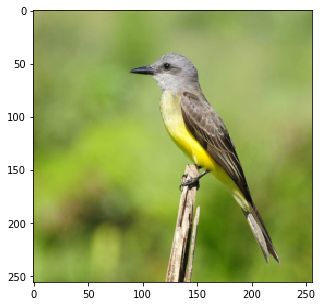

In [6]:
print(x.shape)
loader.imshow(x[0])
print(y.shape)
print(class_ids)

In [7]:
caption = y[:,np.random.randint(0,10),:]
caption.shape

torch.Size([2, 20])

In [8]:
class RNN_ENCODER(nn.Module):
    def __init__(self, ntoken, ninput=300, drop_prob=0.5,
                 nhidden=128, nlayers=1, bidirectional=True):
        super(RNN_ENCODER, self).__init__()
        
        self.ntoken = ntoken  # size of the dictionary
        self.ninput = ninput  # size of each embedding vector
        self.drop_prob = drop_prob  # probability of an element to be zeroed
        self.nlayers = nlayers  # Number of recurrent layers
        self.bidirectional = bidirectional

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1

        self.nhidden = nhidden // self.num_directions

        self.encoder = nn.Embedding(self.ntoken, self.ninput)
        self.drop = nn.Dropout(self.drop_prob)
        
        self.rnn = nn.LSTM(self.ninput, self.nhidden,
                           self.nlayers, batch_first=True,
                           dropout=self.drop_prob,
                           bidirectional=self.bidirectional)


    def init_hidden(self, batch_size):
        return (torch.zeros(self.nlayers* self.num_directions, batch_size, self.nhidden).cuda(),
                torch.zeros(self.nlayers* self.num_directions, batch_size, self.nhidden).cuda())

    def forward(self, captions):
    
        emb = self.drop(self.encoder(captions))        
        output, self.hidden = self.rnn(emb, self.hidden)
        words_emb = output.transpose(1, 2)
        
        sent_emb = self.hidden[0].transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nhidden * self.num_directions)
        
        return words_emb, sent_emb


In [9]:
model = RNN_ENCODER(ntoken = 5450).to(device)
model.hidden = model.init_hidden(batch_size)
word_emb, sent_emb = model.forward(caption)
print(word_emb.shape, sent_emb.shape)

torch.Size([2, 128, 20]) torch.Size([2, 128])


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [10]:
from torchvision import models
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

In [11]:
def conv1x1(in_planes, out_planes, bias=False):
    "1x1 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                     padding=0, bias=bias)


def conv3x3(in_planes, out_planes):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
padding=1, bias=False)

In [12]:
class CNN_ENCODER(nn.Module):
    def __init__(self, nef):
        super(CNN_ENCODER, self).__init__()
        self.nef = 128  # define a uniform ranker

        model = models.inception_v3().to(device)
        url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
        model.load_state_dict(model_zoo.load_url(url))
        for param in model.parameters():
            param.requires_grad = False
        print('Load pretrained model from ', url)
        self.define_module(model)
        self.init_trainable_weights()

    def define_module(self, model):
        self.Conv2d_1a_3x3 = model.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = model.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = model.Conv2d_2b_3x3
        self.Conv2d_3b_1x1 = model.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = model.Conv2d_4a_3x3
        self.Mixed_5b = model.Mixed_5b
        self.Mixed_5c = model.Mixed_5c
        self.Mixed_5d = model.Mixed_5d
        self.Mixed_6a = model.Mixed_6a
        self.Mixed_6b = model.Mixed_6b
        self.Mixed_6c = model.Mixed_6c
        self.Mixed_6d = model.Mixed_6d
        self.Mixed_6e = model.Mixed_6e
        self.Mixed_7a = model.Mixed_7a
        self.Mixed_7b = model.Mixed_7b
        self.Mixed_7c = model.Mixed_7c

        self.emb_features = conv1x1(768, self.nef)
        self.emb_cnn_code = nn.Linear(2048, self.nef)

    def init_trainable_weights(self):
        initrange = 0.1
        self.emb_features.weight.data.uniform_(-initrange, initrange)
        self.emb_cnn_code.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        features = None
        # --> fixed-size input: batch x 3 x 299 x 299

        x = nn.Upsample(size=(299, 299), mode='bilinear')(x)
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192

        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288

        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768

        # image region features
        features = x
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        # x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048
        # global image features
        cnn_code = self.emb_cnn_code(x)
        # 512
        if features is not None:
            features = self.emb_features(features)
        return features, cnn_code

In [13]:
image_encoder = CNN_ENCODER(128).to(device)

Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth


In [14]:
 img_features, img_sent_code = image_encoder(x)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [15]:
print(word_emb.shape, sent_emb.shape, img_features.shape, img_sent_code.shape)
from torch.autograd import Variable
label = Variable(torch.LongTensor(range(batch_size))).cuda()

torch.Size([2, 128, 20]) torch.Size([2, 128]) torch.Size([2, 128, 17, 17]) torch.Size([2, 128])


In [17]:
def func_attention(query, context, gamma1):
    """
    query: batch x ndf x queryL
    context: batch x ndf x ih x iw (sourceL=ihxiw)
    mask: batch_size x sourceL
    """
    batch_size, queryL = query.size(0), query.size(2)
    ih, iw = context.size(2), context.size(3)
    sourceL = ih * iw

    # --> batch x sourceL x ndf
    context = context.view(batch_size, -1, sourceL)
    contextT = torch.transpose(context, 1, 2).contiguous()

    # Get attention
    # (batch x sourceL x ndf)(batch x ndf x queryL)
    # -->batch x sourceL x queryL
    attn = torch.bmm(contextT, query) # Eq. (7) in AttnGAN paper
    # --> batch*sourceL x queryL
    attn = attn.view(batch_size*sourceL, queryL)
    attn = nn.Softmax()(attn)  # Eq. (8)

    # --> batch x sourceL x queryL
    attn = attn.view(batch_size, sourceL, queryL)
    # --> batch*queryL x sourceL
    attn = torch.transpose(attn, 1, 2).contiguous()
    attn = attn.view(batch_size*queryL, sourceL)
    #  Eq. (9)
    attn = attn * gamma1
    attn = nn.Softmax()(attn)
    attn = attn.view(batch_size, queryL, sourceL)
    # --> batch x sourceL x queryL
    attnT = torch.transpose(attn, 1, 2).contiguous()

    # (batch x ndf x sourceL)(batch x sourceL x queryL)
    # --> batch x ndf x queryL
    weightedContext = torch.bmm(context, attnT)
    
    return weightedContext, attn.view(batch_size, -1, ih, iw)


def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    """Returns cosine similarity between x1 and x2, computed along dim.
    """
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()


def words_loss(img_features, words_emb, labels, batch_size, class_ids):
    """
        words_emb(query): batch x nef x seq_len
        img_features(context): batch x nef x 17 x 17
    """
    masks = []
    att_maps = []
    similarities = []
    for i in range(batch_size):
        if class_ids is not None:
            mask = (class_ids == class_ids[i]).astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
                
        words_num = words_emb.shape[2]
                
        # -> 1 x nef x words_num
        word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()
        # -> batch_size x nef x words_num
        word = word.repeat(batch_size, 1, 1)
        # batch x nef x 17*17
        
        context = img_features
        """
            word(query): batch x nef x words_num
            context: batch x nef x 17 x 17
            weiContext: batch x nef x words_num
            attn: batch x words_num x 17 x 17
        """
        weiContext, attn = func_attention(word, context,5)

        att_maps.append(attn[i].unsqueeze(0).contiguous())
        # --> batch_size x words_num x nef
        word = word.transpose(1, 2).contiguous()
        weiContext = weiContext.transpose(1, 2).contiguous()
        
        # --> batch_size*words_num x nef
        word = word.view(batch_size * words_num, -1)
        weiContext = weiContext.view(batch_size * words_num, -1)
        
        # -->batch_size*words_num
        row_sim = cosine_similarity(word, weiContext)
        # --> batch_size x words_num
        row_sim = row_sim.view(batch_size, words_num)

        # Eq. (10)
        row_sim.mul_(5).exp_()
        row_sim = row_sim.sum(dim=1, keepdim=True)
        row_sim = torch.log(row_sim)

        # --> 1 x batch_size
        # similarities(i, j): the similarity between the i-th image and the j-th text description
        similarities.append(row_sim)

    # batch_size x batch_size
    similarities = torch.cat(similarities, 1)

    if class_ids is not None:
        masks = np.concatenate(masks, 0)
        # masks: batch_size x batch_size
        masks = torch.ByteTensor(masks).cuda()

    similarities = similarities * 10

    if class_ids is not None:
        similarities.data.masked_fill_(masks, -float('inf'))
   
    similarities1 = similarities.transpose(0, 1)

    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(similarities, labels)
        loss1 = nn.CrossEntropyLoss()(similarities1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1, att_maps

w_loss0, w_loss1, attn_maps = words_loss(img_features, word_emb, label, batch_size, class_ids)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [18]:
def sent_loss(cnn_code, rnn_code, labels, class_ids,
              batch_size, eps=1e-8):
    # ### Mask mis-match samples  ###
    # that come from the same class as the real sample ###
    masks = []
    if class_ids is not None:
        for i in range(batch_size):
            mask = (class_ids == class_ids[i]).astype(np.uint8)
            mask[i] = 0
            masks.append(mask.reshape((1, -1)))
        masks = np.concatenate(masks, 0)
        # masks: batch_size x batch_size
        masks = torch.ByteTensor(masks).cuda()

    # --> seq_len x batch_size x nef
    if cnn_code.dim() == 2:
        cnn_code = cnn_code.unsqueeze(0)
        rnn_code = rnn_code.unsqueeze(0)

    # cnn_code_norm / rnn_code_norm: seq_len x batch_size x 1
    cnn_code_norm = torch.norm(cnn_code, 2, dim=2, keepdim=True)
    rnn_code_norm = torch.norm(rnn_code, 2, dim=2, keepdim=True)
        
    # scores* / norm*: seq_len x batch_size x batch_size
    scores0 = torch.bmm(cnn_code, rnn_code.transpose(1, 2))
    norm0 = torch.bmm(cnn_code_norm, rnn_code_norm.transpose(1, 2))
    scores0 = scores0 / norm0.clamp(min=eps) * 10
    
    # --> batch_size x batch_size
    scores0 = scores0.squeeze()

    if class_ids is not None:
        scores0.data.masked_fill_(masks, -float('inf'))
    scores1 = scores0.transpose(0, 1)
    
    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(scores0, labels)
        loss1 = nn.CrossEntropyLoss()(scores1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1

s_loss0, s_loss1 = sent_loss(img_sent_code, sent_emb, label, class_ids, batch_size)

In [26]:
import itertools
lr = 0.0001
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), image_encoder.parameters()), lr, betas=(0.5, 0.999))
num_epochs = 100
UPDATE_INTERVAL = 5

num_images = 9429
for epoch in range(0, num_epochs):
    s_total_loss0 = 0
    s_total_loss1 = 0
    w_total_loss0 = 0
    w_total_loss1 = 0
    for i in range(num_images // batch_size):
        x, y, class_ids = next(loader.get_data(True))
        caption = y[:,np.random.randint(0,10),:]

        model.zero_grad()
        image_encoder.zero_grad()
        
        words_features, sent_code = image_encoder(x)
        
        model.hidden = model.init_hidden(batch_size)
        words_emb, sent_emb = model.forward(caption)
        
#         print(words_emb.shape, sent_emb.shape, words_features.shape, sent_code.shape)
        
        w_loss0, w_loss1, attn_maps = words_loss(words_features, words_emb, label, batch_size, class_ids)
    
        w_total_loss0 += w_loss0.data
        w_total_loss1 += w_loss1.data
        loss = w_loss0 + w_loss1

        s_loss0, s_loss1 = sent_loss(sent_code, sent_emb, label, class_ids, batch_size)
        loss += s_loss0 + s_loss1
        s_total_loss0 += s_loss0.data
        s_total_loss1 += s_loss1.data
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)
        optimizer.step()
        
        if epoch % UPDATE_INTERVAL == 0:
        
            s_cur_loss0 = s_total_loss0.item() / UPDATE_INTERVAL
            s_cur_loss1 = s_total_loss1.item() / UPDATE_INTERVAL

            w_cur_loss0 = w_total_loss0.item() / UPDATE_INTERVAL
            w_cur_loss1 = w_total_loss1.item() / UPDATE_INTERVAL

            print(s_cur_loss0, s_cur_loss1,w_cur_loss0, w_cur_loss1)
            s_total_loss0 = 0
            s_total_loss1 = 0
            w_total_loss0 = 0
            w_total_loss1 = 0
        
        
        

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/opt/conda/lib/pyt

0.14655025005340577 0.13412506580352784 0.14619483947753906 0.12441253662109375
0.15044746398925782 0.12451531887054443 0.14150390625 0.14003562927246094
0.14207048416137696 0.12427000999450684 0.16180992126464844 0.15209426879882812
0.11267879009246826 0.11420948505401611 0.11563949584960938 0.09863548278808594
0.14376115798950195 0.14504969120025635 0.18323287963867188 0.19239959716796876
0.11522499322891236 0.1215066909790039 0.19638824462890625 0.1346668243408203
0.16473182439804077 0.14232487678527833 0.13931541442871093 0.10744132995605468
0.14932281970977784 0.1345059394836426 0.12224311828613281 0.12220230102539062
0.17516582012176513 0.16113724708557128 0.1475189208984375 0.13949165344238282
0.15852978229522705 0.13456743955612183 0.17031517028808593 0.168536376953125
0.16526612043380737 0.15895516872406007 0.1710895538330078 0.16193580627441406
0.148612904548645 0.1289511203765869 0.10201644897460938 0.10265159606933594
0.16118963956832885 0.16194907426834107 0.12691955566406

0.14870141744613646 0.14566996097564697 0.1570758819580078 0.13261146545410157
0.13515312671661378 0.14931936264038087 0.1663135528564453 0.16621894836425782
0.15324140787124635 0.1512227773666382 0.3607921600341797 0.0943511962890625
0.13839192390441896 0.13838648796081543 0.1619739532470703 0.16308364868164063
0.14357612133026124 0.10460906028747559 0.3973667144775391 0.27268104553222655
0.18077141046524048 0.17985595464706422 0.17537841796875 0.15408935546875
0.16218769550323486 0.16254143714904784 0.22703819274902343 0.1428752899169922
0.15187493562698365 0.14385566711425782 0.15020484924316407 0.12764892578125
0.14762133359909058 0.13699672222137452 0.11736297607421875 0.12871856689453126
0.16654720306396484 0.16478142738342286 0.14732666015625 0.15293045043945314
0.1588150978088379 0.15705103874206544 0.09974861145019531 0.08851470947265624
0.15720171928405763 0.15353009700775147 0.16712112426757814 0.16666755676269532
0.13820730447769164 0.132260525226593 0.1300689697265625 0.12

0.1277001142501831 0.12212297916412354 0.26428985595703125 0.10083389282226562
0.1589348554611206 0.1556445598602295 0.1674571990966797 0.12226829528808594
0.14151370525360107 0.14098076820373534 0.17572669982910155 0.1701335906982422
0.10554168224334717 0.10440536737442016 0.1773082733154297 0.1761310577392578
0.12122910022735596 0.12176203727722168 0.1652233123779297 0.17409858703613282
0.155405592918396 0.15361196994781495 0.16452560424804688 0.12830085754394532
0.15394222736358643 0.12562381029129027 0.13717918395996093 0.17198524475097657
0.24048657417297364 0.23010411262512206 0.24710216522216796 0.13434886932373047
0.11699433326721191 0.11641252040863037 0.2890495300292969 0.17233848571777344
0.13712599277496337 0.11496715545654297 0.17430648803710938 0.17373504638671874
0.14783719778060914 0.1343622922897339 0.07911148071289062 0.07787971496582032
0.1299372673034668 0.13677268028259276 0.15931663513183594 0.1352252960205078
0.11928744316101074 0.11774561405181885 0.097570419311

0.14386773109436035 0.150955867767334 0.15797271728515624 0.1307140350341797
0.11424598693847657 0.10881037712097168 0.29159393310546877 0.12253646850585938
0.16571906805038453 0.15972964763641356 0.20242881774902344 0.21918258666992188
0.1912282943725586 0.1869557499885559 0.16769676208496093 0.16567039489746094
0.161754834651947 0.16030224561691284 0.14747657775878906 0.15313644409179689
0.13588643074035645 0.13442375659942626 0.15214042663574218 0.16705360412597656
0.15002636909484862 0.14485071897506713 0.1492847442626953 0.18885498046875
0.12290010452270508 0.11633236408233642 0.1784984588623047 0.11044197082519532
0.12861816883087157 0.12804371118545532 0.18126869201660156 0.07561721801757812
0.18095418214797973 0.15248303413391112 0.22133903503417968 0.18241386413574218
0.13663845062255858 0.13702929019927979 0.22588768005371093 0.12028541564941406
0.1231395959854126 0.12476823329925538 0.177099609375 0.17706718444824218
0.18979015350341796 0.17578535079956054 0.0926479339599609

KeyboardInterrupt: 